In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = 'darkgrid', font_scale = 1.4)
from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedGroupKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.utils import resample

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

## Data

In [138]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print('Train.shape: ', train.shape)
print('Test.shape: ', test.shape)
train.head(5)

Train.shape:  (8693, 14)
Test.shape:  (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


##### Missing values

In [139]:
print('Train missing values:')
print(train.isna().sum())
print()
print('Test missing values:')
print(test.isna().sum())

Train missing values:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Test missing values:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


##### Duplicates

In [140]:
print(f'Duplicates in train: {train.duplicated().sum()}, ({np.round(100 * train.duplicated().sum() / len(train), 1)}%)')
print(f'Duplicates in test: {test.duplicated().sum()}, ({np.round(100 * test.duplicated().sum() / len(test), 1)}%)')

Duplicates in train: 0, (0.0%)
Duplicates in test: 0, (0.0%)


##### Cardinality of features

In [141]:
train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

##### Data types

In [142]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

## EDA

##### Target Distribution

Text(0.5, 1.0, 'Target Distribution')

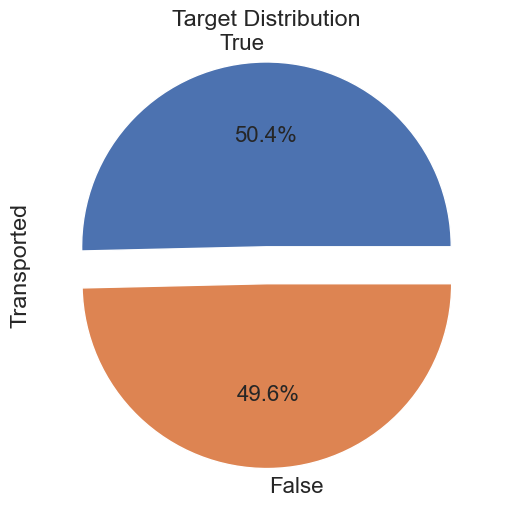

In [143]:
plt.figure(figsize = (6, 6))
# plt.pie(train['Transported'].value_counts(), explode = [0.1, 0.1], labels = ['True', 'False'], autopct = '%.1f%%', shadow = False, textprops = {'fontsize': 16})
# plt.title('Target Distribution')
# plt.legend()
train['Transported'].value_counts().plot.pie(explode = [0.1, 0.1], autopct = '%.1f%%', shadow = False, textprops = {'fontsize': 16}).set_title('Target Distribution')

##### Continuous features

Text(0.5, 0, 'Age(years)')

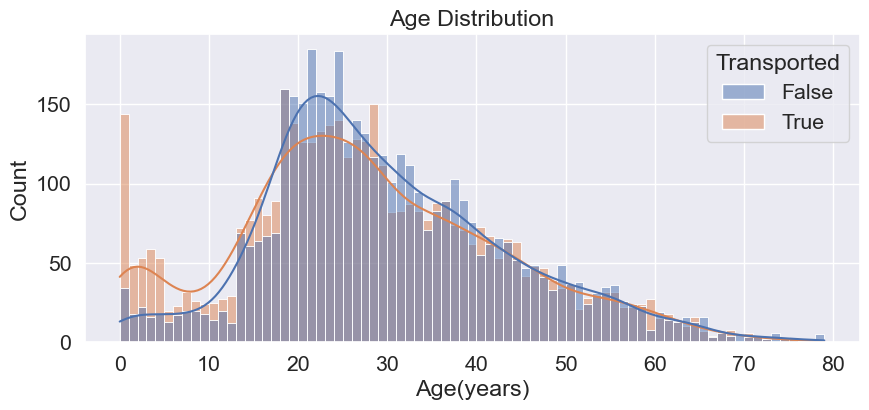

In [144]:
plt.figure(figsize = (10, 4))
sns.histplot(data = train, x = 'Age', hue = 'Transported', binwidth = 1, kde = True)
plt.title('Age Distribution')
plt.xlabel('Age(years)')

*We can see that:*
* 0-18 year olds are more likely to be transported
* 18-25 year olds are more likely not to be transported
* older than 25 year olds are about equally likely to be transported or not

*Insight:*
* Indicate whether a person is a child, adolescent, or adult

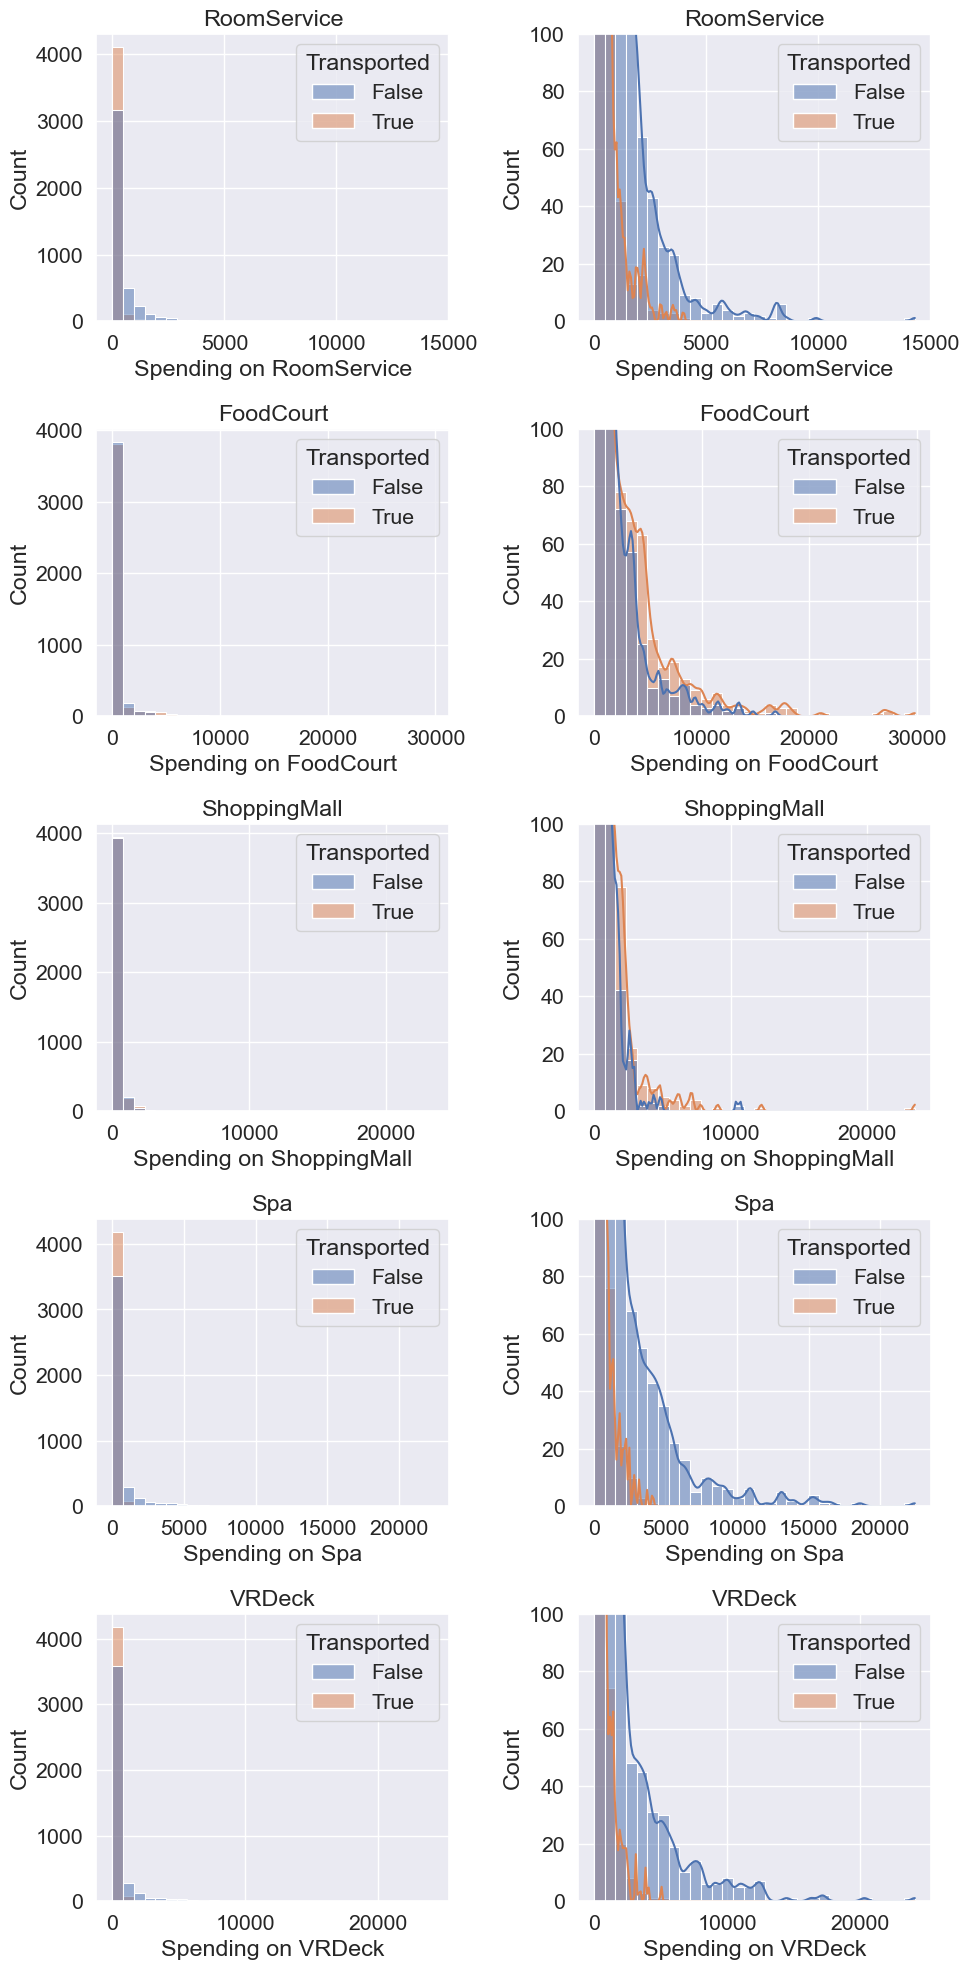

In [145]:
# Expenditure features
exp_fea = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

fig = plt.figure(figsize = (10, 20))
for i, var in enumerate(exp_fea):
    # left plot
    ax = fig.add_subplot(5, 2, 2 * i + 1)
    sns.histplot(data = train, x = var, axes = ax, bins = 30, kde = False, hue = 'Transported')
    # plt.ylim([0, 100])
    ax.set_xlabel('Spending on ' + var)
    ax.set_title(var)

    # right plot
    ax = fig.add_subplot(5, 2, 2 * i + 2)
    sns.histplot(data = train, x = var, axes = ax, bins = 30, kde = True, hue = 'Transported')
    plt.ylim([0, 100])
    ax.set_xlabel('Spending on ' + var)
    ax.set_title(var)
fig.tight_layout()
plt.show()

*What we have from the plots:*
* Most people do not spend any money
* The distribution of spending decays exponentially.
* A small number of outliers exist.
* People who transport tend to spend less
* RoomService, Spa, and VRDeck have different distributions to FoodCourt and ShoppingMall: we can think of this as luxury vs essential amenities.

*Insight:*
* Create new feature that tracks the total expenditure across all 5 amenities.
* Create a binary feature to indicate if the person has not spent anything.
* Take the log transform to reduce skew.

##### Categorical features

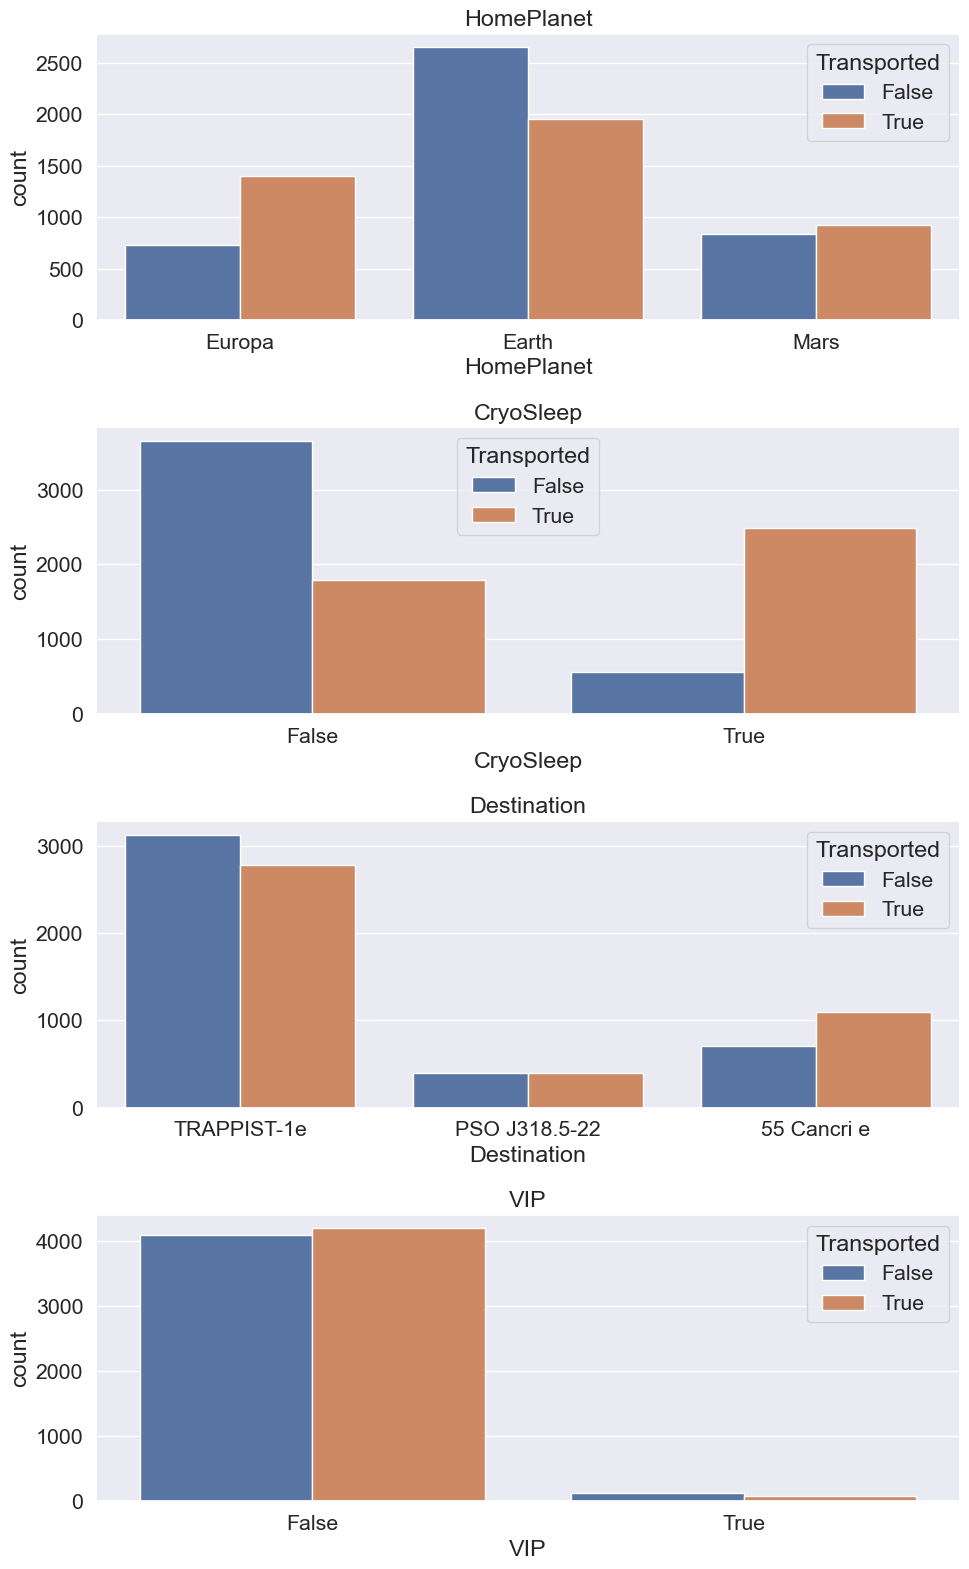

In [146]:
cat_fea = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

fig = plt.figure(figsize = (10, 16))
for i, var in enumerate(cat_fea):
    ax = fig.add_subplot(4, 1, i + 1)
    sns.countplot(data = train, x = var, axes = ax, hue = 'Transported')
    ax.set_title(var)
fig.tight_layout()
plt.show()

*What we can find:*
* CryoSleep appears to be useful for people who transport
* VIP is not a useful feature that target split by VIP is more or less equal.

*Insight:*
* May drop VIP to prevent overfitting

##### Qualitative features

In [147]:
# Cannot be plotted
qual_fea = ['PassengerId', 'Cabin', 'Name']
train[qual_fea].head(5)

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


*Note:*
* PassengerId takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group.
* Cabin takes the form deck/num/side, where side can be either P for Port or S for Starboard.

*Insight:*
* May extract group and group size from PassengerId
* May extract the deck, num, and side from Cabin
* Identify families from the lastnames

## Feature engineering

Bin age features into groups. This will be helpful for filling missing values like expenditure according to age.

Text(0.5, 1.0, 'Age group distribution')

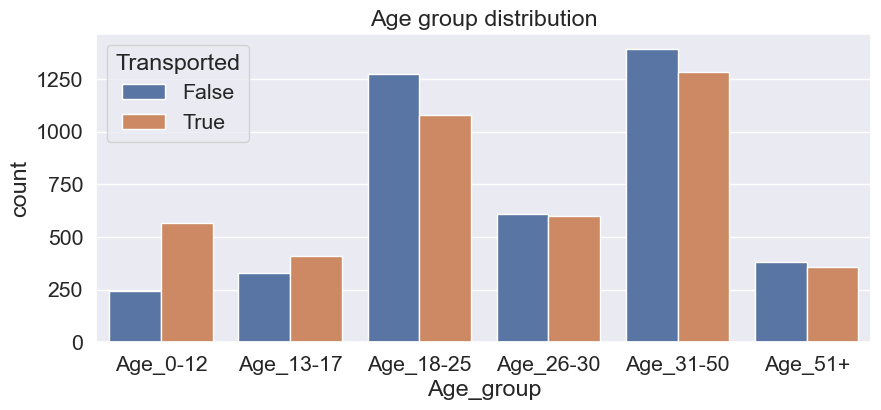

In [148]:
train['Age_group'] = np.nan
train.loc[train['Age'] <= 12, 'Age_group'] = 'Age_0-12'
train.loc[(train['Age'] > 12) & (train['Age'] < 18), 'Age_group'] = 'Age_13-17'
train.loc[(train['Age'] >= 18) & (train['Age'] <= 25), 'Age_group'] = 'Age_18-25'
train.loc[(train['Age'] > 25) & (train['Age'] <= 30), 'Age_group'] = 'Age_26-30'
train.loc[(train['Age'] > 30) & (train['Age'] <= 50), 'Age_group'] = 'Age_31-50'
train.loc[train['Age'] > 50, 'Age_group'] = 'Age_51+'

test['Age_group'] = np.nan
test.loc[test['Age'] <= 12, 'Age_group'] = 'Age_0-12'
test.loc[(test['Age'] > 12) & (test['Age'] < 18), 'Age_group'] = 'Age_13-17'
test.loc[(test['Age'] >= 18) & (test['Age'] <= 25), 'Age_group'] = 'Age_18-25'
test.loc[(test['Age'] > 25) & (test['Age'] <= 30), 'Age_group'] = 'Age_26-30'
test.loc[(test['Age'] > 30) & (test['Age'] <= 50), 'Age_group'] = 'Age_31-50'
test.loc[test['Age'] > 50, 'Age_group'] = 'Age_51+'

plt.figure(figsize = (10, 4))
g = sns.countplot(data = train, x = 'Age_group', hue = 'Transported', order = ['Age_0-12','Age_13-17','Age_18-25','Age_26-30','Age_31-50','Age_51+'])
plt.title('Age group distribution')

##### Expenditure

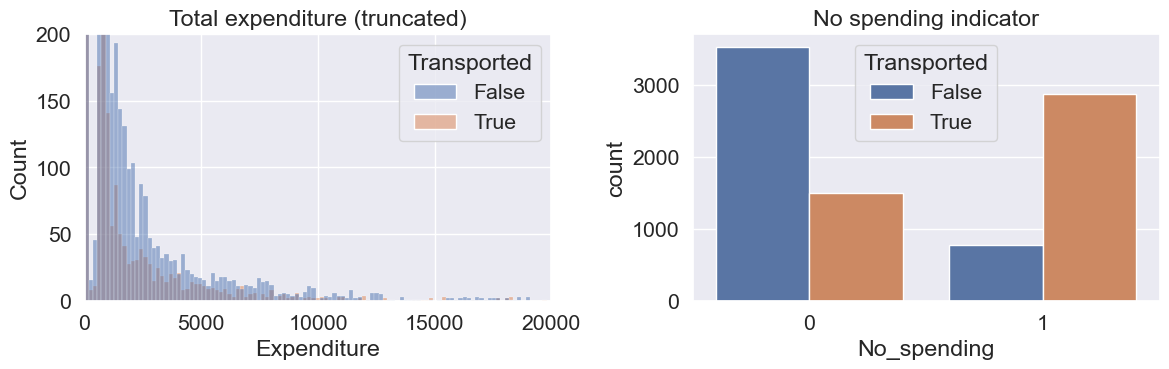

In [149]:
train['Expenditure'] = train[exp_fea].sum(axis = 1)
train['No_spending'] = (train['Expenditure'] == 0).astype(int)
test['Expenditure'] = test[exp_fea].sum(axis = 1)
test['No_spending'] = (test['Expenditure'] == 0).astype(int)

fig = plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
sns.histplot(data = train, x = 'Expenditure', hue = 'Transported', bins = 200)
plt.title('Total expenditure (truncated)')
plt.xlim([0, 20000])
plt.ylim([0, 200])

plt.subplot(1, 2, 2)
sns.countplot(data = train, x = 'No_spending', hue = 'Transported')
plt.title('No spending indicator')
fig.tight_layout()

##### Passenger group

Extract passenger group and group size form PassengerId

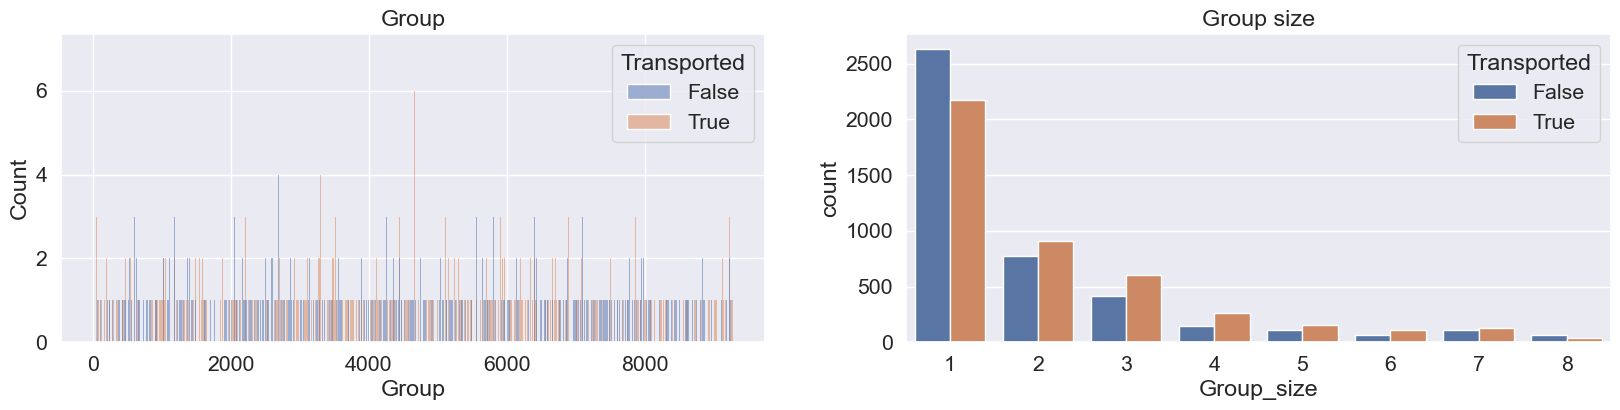

In [150]:
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

train['Group_size'] = train['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])
test['Group_size'] = test['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])

plt.figure(figsize = (20, 4))
plt.subplot(1, 2, 1)
sns.histplot(data = train, x = 'Group', hue = 'Transported', binwidth = 1)
plt.title('Group')
fig.tight_layout()

plt.subplot(1, 2, 2)
sns.countplot(data = train, x = 'Group_size', hue = 'Transported')
plt.title('Group size')
fig.tight_layout()

The Group size on the other hand should be a useful feature. In fact, we can compress the feature further by creating a 'Solo' column that tracks whether someone is travelling on their own or not. The figure on the right shows that group size=1 is less likely to be transported than group size>1.

(0.0, 3000.0)

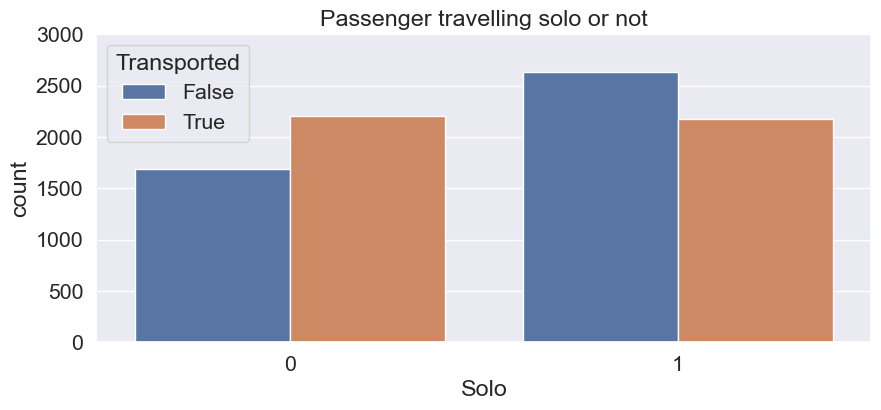

In [151]:
train['Solo'] = (train['Group_size'] == 1).astype(int)
test['Solo'] = (test['Group_size'] == 1).astype(int)

plt.figure(figsize = (10, 4))
sns.countplot(data = train, x = 'Solo', hue = 'Transported')
plt.title('Passenger travelling solo or not')
plt.ylim([0, 3000])

##### Cabin

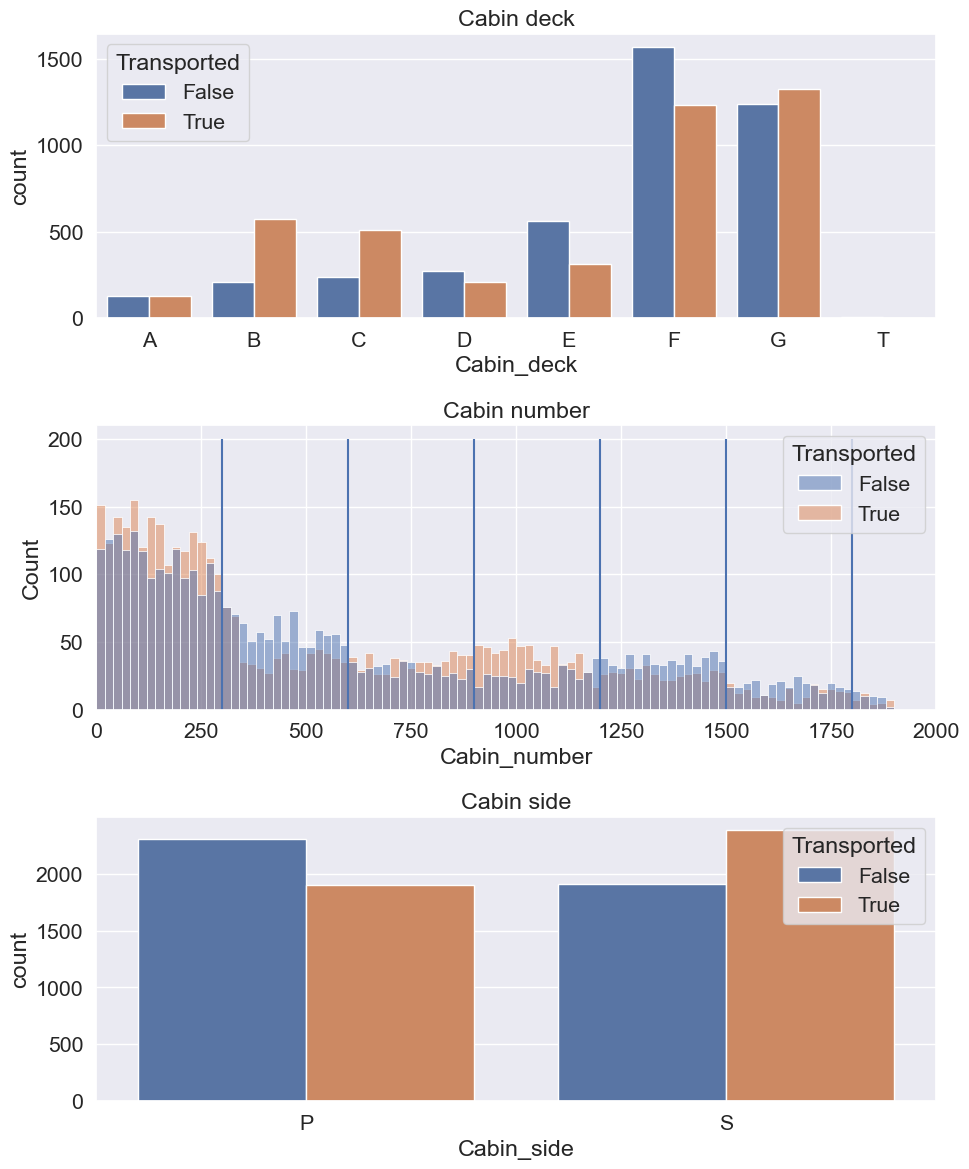

In [152]:
# Fill the nan so we can split the feature
train['Cabin'].fillna('Z/9999/Z', inplace = True)
test['Cabin'].fillna('Z/9999/Z', inplace = True)

train['Cabin_deck'] = train['Cabin'].apply(lambda x: x.split('/')[0])
train['Cabin_number'] = train['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
train['Cabin_side'] = train['Cabin'].apply(lambda x: x.split('/')[2])
test['Cabin_deck'] = test['Cabin'].apply(lambda x: x.split('/')[0])
test['Cabin_number'] = test['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
test['Cabin_side'] = test['Cabin'].apply(lambda x: x.split('/')[2])

# Put nan(s) back
train.loc[train['Cabin_deck'] == 'Z', 'Cabin_deck'] = np.nan
train.loc[train['Cabin_number'] == 9999, 'Cabin_number'] = np.nan
train.loc[train['Cabin_side'] == 'Z', 'Cabin_side'] = np.nan
test.loc[test['Cabin_deck'] == 'Z', 'Cabin_deck'] = np.nan
test.loc[test['Cabin_number'] == 9999, 'Cabin_number'] = np.nan
test.loc[test['Cabin_side'] == 'Z', 'Cabin_side'] = np.nan

train.drop('Cabin', axis = 1, inplace = True)
test.drop('Cabin', axis = 1, inplace = True)

fig = plt.figure(figsize = (10, 12))
plt.subplot(3, 1, 1)
sns.countplot(data = train, x = 'Cabin_deck', hue = 'Transported', order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])
plt.title('Cabin deck')

plt.subplot(3, 1, 2)
sns.histplot(data = train, x = 'Cabin_number', hue = 'Transported', binwidth = 20)
plt.vlines([300, 600, 900, 1200, 1500, 1800], ymin = 0, ymax = 200, colors = 'b')
plt.title('Cabin number')
plt.xlim([0, 2000])

plt.subplot(3, 1, 3)
sns.countplot(data = train, x = 'Cabin_side', hue = 'Transported')
plt.title('Cabin side')

fig.tight_layout()

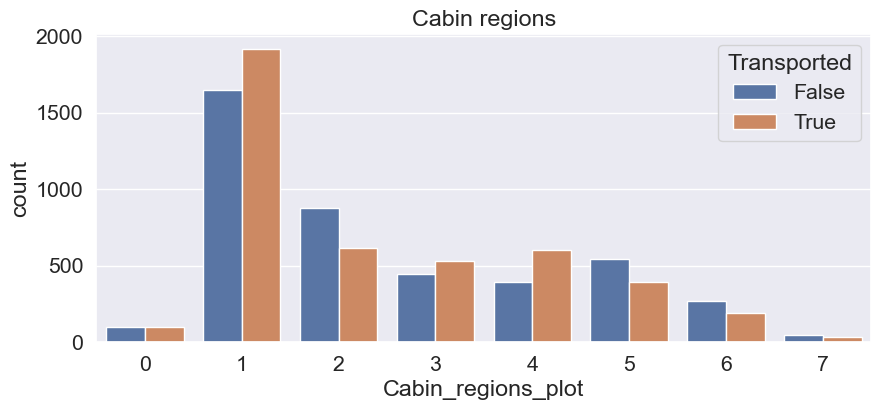

In [153]:
# New feature
train['Cabin_region1'] = (train['Cabin_number'] < 300).astype(int)
train['Cabin_region2'] = ((train['Cabin_number'] >= 300) & (train['Cabin_number'] < 600)).astype(int)
train['Cabin_region3'] = ((train['Cabin_number'] >= 600) & (train['Cabin_number'] < 900)).astype(int)
train['Cabin_region4'] = ((train['Cabin_number'] >= 900) & (train['Cabin_number'] < 1200)).astype(int)
train['Cabin_region5'] = ((train['Cabin_number'] >= 1200) & (train['Cabin_number'] < 1500)).astype(int)
train['Cabin_region6'] = ((train['Cabin_number'] >= 1500) & (train['Cabin_number'] < 1800)).astype(int)
train['Cabin_region7'] = (train['Cabin_number'] >= 1800).astype(int)

test['Cabin_region1'] = (test['Cabin_number'] < 300).astype(int)
test['Cabin_region2'] = ((test['Cabin_number'] >= 300) & (test['Cabin_number'] < 600)).astype(int)
test['Cabin_region3'] = ((test['Cabin_number'] >= 600) & (test['Cabin_number'] < 900)).astype(int)
test['Cabin_region4'] = ((test['Cabin_number'] >= 900) & (test['Cabin_number'] < 1200)).astype(int)
test['Cabin_region5'] = ((test['Cabin_number'] >= 1200) & (test['Cabin_number'] < 1500)).astype(int)
test['Cabin_region6'] = ((test['Cabin_number'] >= 1500) & (test['Cabin_number'] < 1800)).astype(int)
test['Cabin_region7'] = (test['Cabin_number'] >= 1800).astype(int)

plt.figure(figsize = (10, 4))
train['Cabin_regions_plot'] = (train['Cabin_region1'] + 2 * train['Cabin_region2'] + 3 * train['Cabin_region3'] + 4 * train['Cabin_region4'] + 5 * train['Cabin_region5'] + 6 * train['Cabin_region6'] + 7 * train['Cabin_region7'])
sns.countplot(data = train, x = 'Cabin_regions_plot', hue = 'Transported')
plt.title('Cabin regions')

train.drop('Cabin_regions_plot', axis = 1, inplace = True)

##### Lastname

Calculate family size from last name

Text(0.5, 1.0, 'Family size')

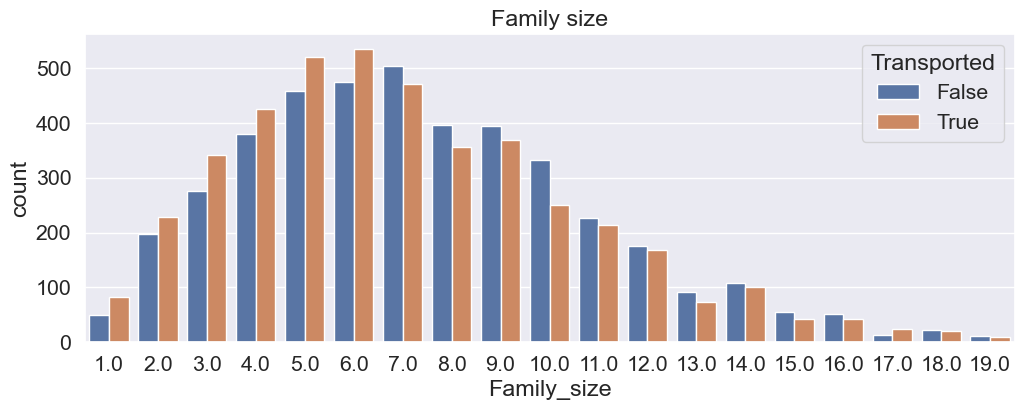

In [154]:
# Fill the nan(s)
train['Name'].fillna('Unknown, Unknown', inplace = True)
test['Name'].fillna('Unknown Unknown', inplace = True)

train['Lastname'] = train['Name'].str.split().str[-1]
test['Lastname'] = test['Name'].str.split().str[-1]

train['Family_size'] = train['Lastname'].map(lambda x: pd.concat([train['Lastname'], test['Lastname']]).value_counts()[x])
test['Family_size'] = test['Lastname'].map(lambda x: pd.concat([train['Lastname'], test['Lastname']]).value_counts()[x])

# Put the nan(s) back in
train.loc[train['Lastname'] == 'Unknown', 'Lastname'] = np.nan
train.loc[train['Family_size'] > 100, 'Family_size'] = np.nan
test.loc[test['Lastname'] == 'Unknown', 'Lastname'] = np.nan
test.loc[test['Family_size'] > 100, 'Family_size'] = np.nan

train.drop('Name', axis = 1, inplace = True)
test.drop('Name', axis = 1, inplace = True)

plt.figure(figsize = (12, 4))
sns.countplot(data = train, x = 'Family_size', hue = 'Transported')
plt.title('Family size')

## Missing values

##### Combine train and test set

Easier to fill out the missing values

In [155]:
y = train['Transported'].copy().astype(int)
x = train.drop('Transported', axis = 1).copy()

data = pd.concat([x, test], axis = 0).reset_index(drop = True)

##### Explore missing values

In [156]:
na_cols = data.columns[data.isna().any()].tolist()
data[na_cols].isna().sum()
mv = pd.DataFrame(data[na_cols].isna().sum(), columns = ['Number_missing'])
mv['Percentage_missing'] = np.round(100 * mv['Number_missing'] / len(data), 2)
mv

,Number_missing,Percentage_missing
HomePlanet,288,2.22
CryoSleep,310,2.39
Destination,274,2.11
Age,270,2.08
VIP,296,2.28
RoomService,263,2.03
FoodCourt,289,2.23
ShoppingMall,306,2.36
Spa,284,2.19
VRDeck,268,2.07


Text(0.5, 1.0, 'Heatmap of missing values')

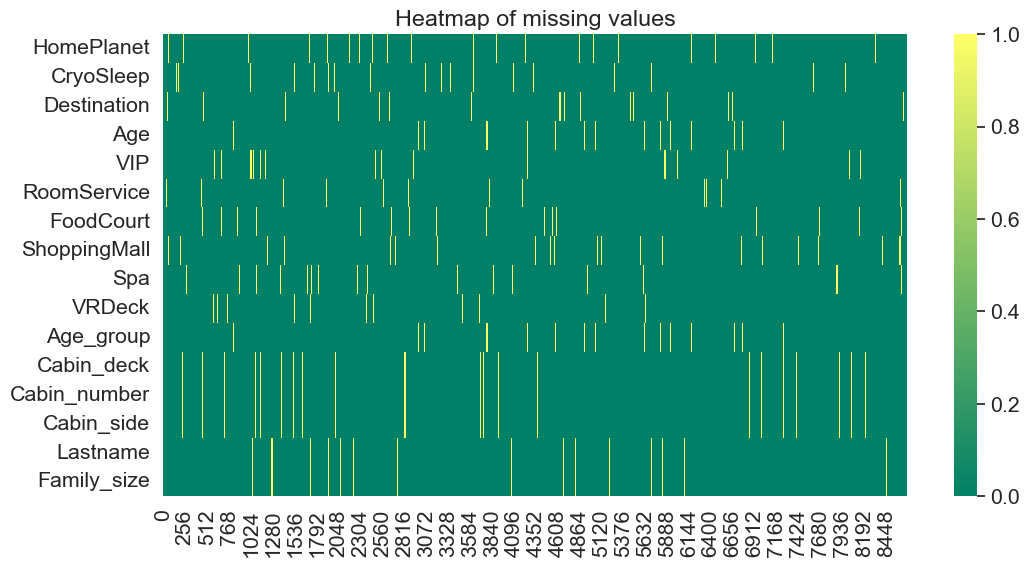

In [157]:
# Heatmap
plt.figure(figsize = (12, 6))
sns.heatmap(data = train[na_cols].isna().T, cmap = 'summer')
plt.title('Heatmap of missing values')

Missing values make up about 2% of the data, which is a relatively small amount. For the most part, they don't seem to be happening at the same time (except the features made from splitting Cabin and Name), but let's inspect closer.

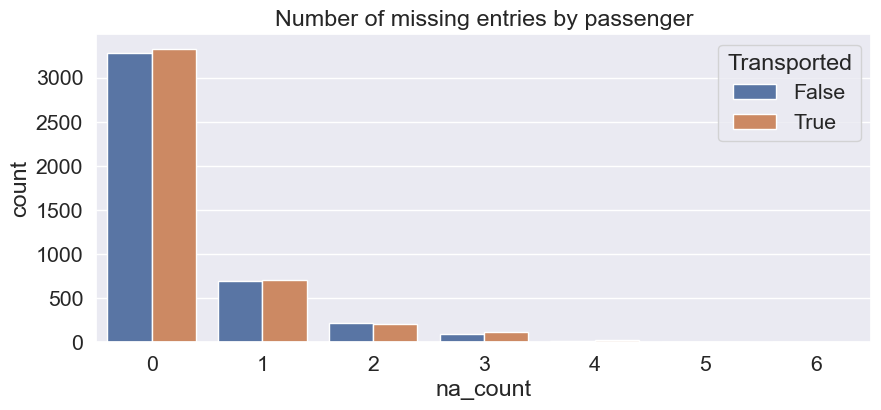

In [158]:
# Countplot of number of missing values by passenger
train['na_count'] = train.isna().sum(axis = 1)
plt.figure(figsize = (10, 4))
sns.countplot(data = train, x = 'na_count', hue = 'Transported')
plt.title('Number of missing entries by passenger')
train.drop('na_count', axis = 1, inplace = True)

*Note:*
* Missing values are independent of the target and for the most part are isolated.
* Even though only 2% of data is missing, about 25% of all passengers have at least 1 missing value.
* PassengerId is the only (original) feature to not have any missing values.

*Insight:*
* Since most of the missing values are isolated it makes sense to try to fill these in as opposed to just dropping rows.
* Is there is a relationship between PassengerId and other features we can fill missing values according to this column.

##### Strategy

The easiest way to deal with missing values is to just use the **median** for continuous features and the **mode** for categorical features. This will work well enough.
If we want to maximise the accuracy of our models then we need to look for patterns within the missing data.
The way to do this is by looking at the **joint distribution** of features, e.g. do passengers from the same group tend to come from the same family.
There are obviously many combinations, so we will just summarise the useful trends I and others have found

##### HomePLanet and Group

In [159]:
# Joint distribution of Group and HomePlanet
GHP_gb = data.groupby(['Group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
GHP_gb.head()

HomePlanet,Earth,Europa,Mars
Group,,,
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,2.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0


Text(0.5, 1.0, 'Number of unique home planets per group')

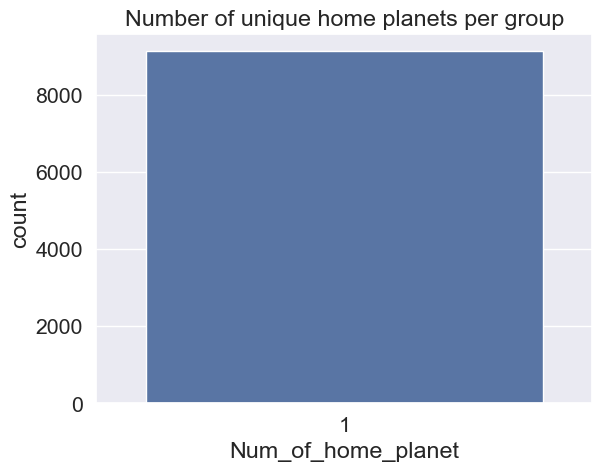

In [160]:
# Countplot of unique values
# If the sum of a row > 1, the group members are from more than 1 home planet
sns.countplot(pd.DataFrame((GHP_gb > 0).sum(axis = 1), columns = ['Num_of_home_planet']), x = 'Num_of_home_planet')
plt.title('Number of unique home planets per group')

This shows that everyone in the same group comes from the same home planet, so we can fill the missing home planet values according to group.

In [161]:
# Missing values before
HP_before = data['HomePlanet'].isna().sum()

# Passenger
GHP_idx = data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Group']).isin(GHP_gb.index)].index

# Fill corresponding missing values
data.loc[GHP_idx, 'HomePlanet'] = data.iloc[GHP_idx, :]['Group'].map(lambda x: GHP_gb.idxmax(axis = 1)[x])

print('HomePlanet missing values before: ', HP_before)
print('HomePlanet missing values after: ', data['HomePlanet'].isna().sum())

HomePlanet missing values before:  288
HomePlanet missing values after:  157


##### HomePlanet and CabinDeck

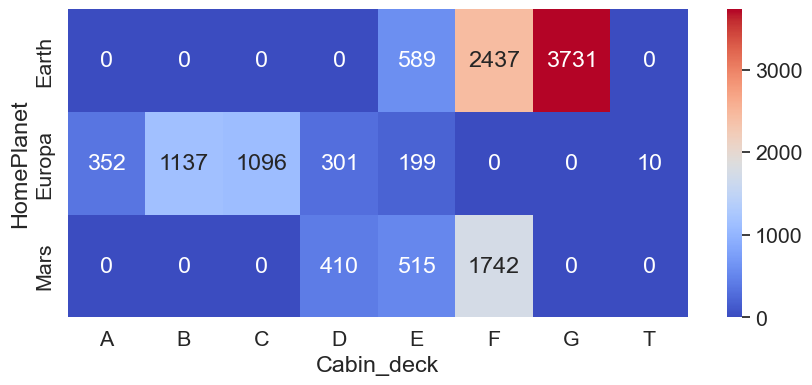

In [162]:
# Joint distribution of CabinDeck and HomePlanet
CDHP_gb = data.groupby(['Cabin_deck', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize = (10, 4))
sns.heatmap(CDHP_gb.T, annot = True, fmt = 'g', cmap = 'coolwarm')
plt.show()

Note:
Passengers on deck A, B, C and T came from Europa.
Passengers on deck G came from Earth.
Passengers on decks D, E, F came from mutiple planets.

In [163]:
# Missing values before
HP_before = data['HomePlanet'].isna().sum()

# Deck A, B, C, T from Europa
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet'] = 'Europa'

# Deck G from Earth
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck'] == 'G'), 'HomePlanet'] = 'Earth'

print('HomePlanet missing values before: ', HP_before)
print('HomePlanet missing values after: ', data['HomePlanet'].isna().sum())

HomePlanet missing values before:  157
HomePlanet missing values after:  94


##### HomePlanet and Surname

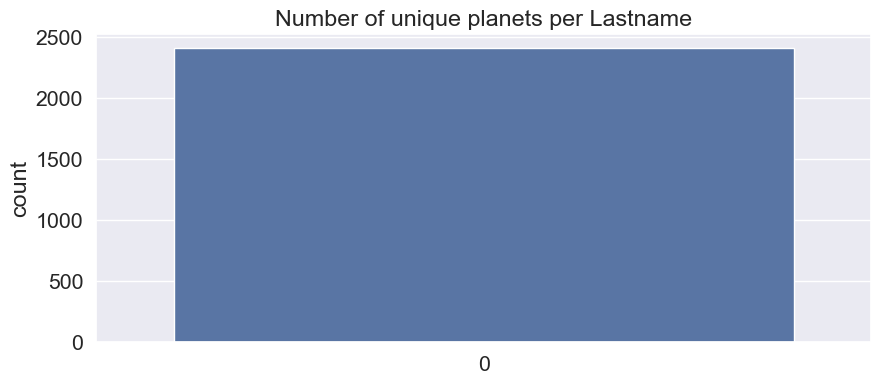

In [164]:
# Joint distribution of Surname and HomePlanet
SHP_gp = data.groupby(['Lastname', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

plt.figure(figsize = (10, 4))
sns.countplot((SHP_gp > 0).sum(axis = 1))
plt.title('Number of unique planets per Lastname')
plt.show()

Everyone with the same lastname came from the same planet

In [165]:
# Missing values before
HP_before = data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a family with known HomePlanet
SHP_idx = data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Lastname']).isin(SHP_gp.index)].index

# Filling corresponding missing values
data.loc[SHP_idx, 'HomePlanet'] = data.iloc[SHP_idx, :]['Lastname'].map(lambda x: SHP_gp.idxmax(axis = 1)[x])

print('HomePlanet missing values before: ', HP_before)
print('HomePlanet missing values after: ', data['HomePlanet'].isna().sum())

HomePlanet missing values before:  94
HomePlanet missing values after:  10


In [166]:
data[data['HomePlanet'].isna()][['PassengerId', 'HomePlanet', 'Destination']]

,PassengerId,HomePlanet,Destination
2274,2443_01,NaN,TRAPPIST-1e
2631,2817_01,NaN,TRAPPIST-1e
3091,3331_01,NaN,TRAPPIST-1e
4548,4840_01,NaN,TRAPPIST-1e
5762,6108_01,NaN,TRAPPIST-1e
8969,0616_01,NaN,TRAPPIST-1e
10583,4052_01,NaN,TRAPPIST-1e
11913,7065_01,NaN,TRAPPIST-1e
12551,8435_01,NaN,TRAPPIST-1e
12725,8775_01,NaN,TRAPPIST-1e


Everyone left is heading towards Trappist-1e, check the joint distribution of HomePlanet and destination then.

##### HomePlanet and Destination

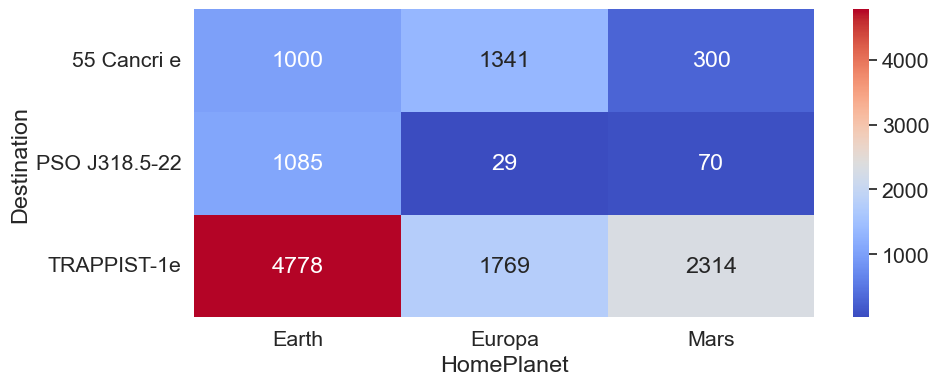

In [167]:
# Joint distribution of HomePlanet and Destination
HPD_gb = data.groupby(['HomePlanet', 'Destination'])['Destination'].size().unstack().fillna(0)

plt.figure(figsize = (10, 4))
sns.heatmap(HPD_gb.T, annot = True, fmt = 'g', cmap = 'coolwarm')
plt.show()

Most people heading towards TRAPPIST-1e came from Earth, so it makes sense to guess they came from there. Also no one on deck D came from Earth.

In [168]:
# Missing values before
HP_before = data['HomePlanet'].isna().sum()

# Filling remaining HomePlanet missing values with Earth (if not on deck D) or Mars (if on deck D)
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck'] != 'D'), 'HomePlanet'] = 'Earth'
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck'] == 'D'), 'HomePlanet'] = 'Mars'

print('HomePlanet missing values before: ', HP_before)
print('HomePlanet missing values after: ', data['HomePlanet'].isna().sum())

HomePlanet missing values before:  10
HomePlanet missing values after:  0


##### Destination

Most people is heading towards TRAPPIST-1e, so just impute this value.

In [169]:
# Missing values before
D_defore = data['Destination'].isna().sum()

data.loc[(data['Destination'].isna()), 'Destination'] = 'TRAPPIST-1e'

print('Destination missing values before: ', D_defore)
print('Destination missing values after: ', data['Destination'].isna().sum())

Destination missing values before:  274
Destination missing values after:  0


##### Lastname and group

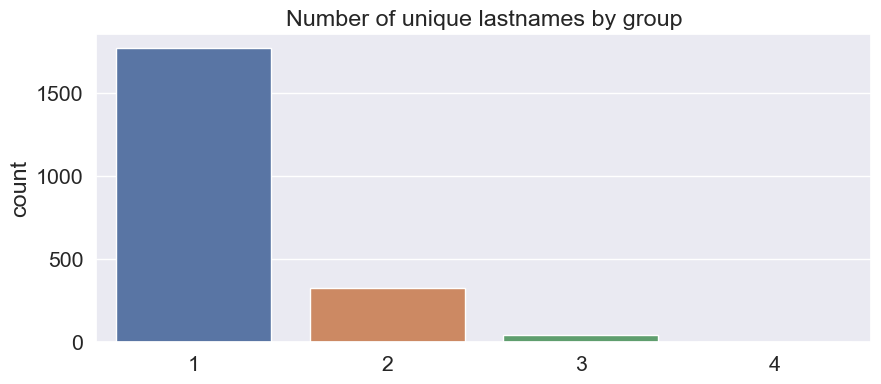

In [170]:
# Joint distribution of group and lastname
GLN_gb = data[data['Group_size'] > 1].groupby(['Group', 'Lastname'])['Lastname'].size().unstack().fillna(0)

plt.figure(figsize = (10, 4))
sns.countplot(x = (GLN_gb > 0).sum(axis = 1))
plt.title('Number of unique lastnames by group')
plt.show()

The majority of groups contain only 1 family, so just fill out the missing value according to the majority lastname in the group

In [171]:
LN_before = data['Lastname'].isna().sum()

missing_ln_idx = data[data['Lastname'].isna()][(data[data['Lastname'].isna()]['Group']).isin(GLN_gb.index)].index

data.loc[missing_ln_idx, 'Lastname'] = data.iloc[missing_ln_idx, :]['Group'].map(lambda x: GLN_gb.idxmax(axis = 1)[x])

print('Lastname missing values before:', LN_before)
print('Lastname missing values after:', data['Lastname'].isna().sum())

Lastname missing values before: 294
Lastname missing values after: 155


Update the family size feature

In [172]:
data['Lastname'].fillna('Unknown', inplace = True)
data['Family_size'] = data['Lastname'].map(lambda x: data['Lastname'].value_counts()[x])
data.loc[data['Lastname'] == 'Unknown', 'Lastname'] = np.nan
data.loc[data['Family_size'] > 100, 'Family_size'] = 0

##### CabinSide and Group

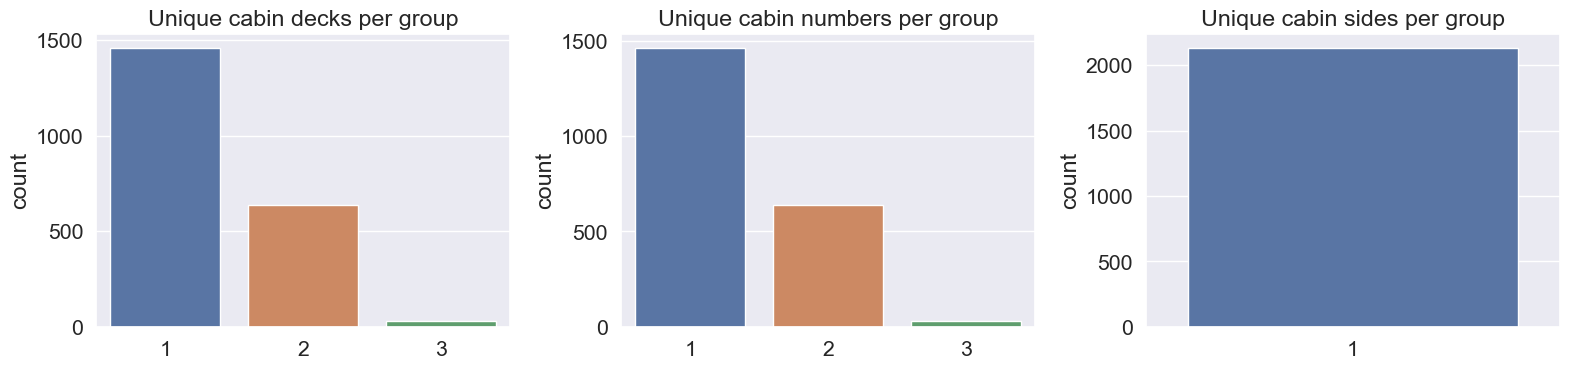

In [173]:
# Joint distribution of Group and Cabin features
GCD_gb = data[data['Group_size'] > 1].groupby(['Group', 'Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)
GCN_gb = data[data['Group_size'] > 1].groupby(['Group', 'Cabin_number'])['Cabin_number'].size().unstack().fillna(0)
GCS_gb = data[data['Group_size'] > 1].groupby(['Group', 'Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

fig = plt.figure(figsize = (16, 4))
plt.subplot(1, 3, 1)
sns.countplot(x = (GCD_gb > 0).sum(axis = 1))
plt.title('Unique cabin decks per group')

plt.subplot(1, 3, 2)
sns.countplot(x = (GCN_gb > 0).sum(axis = 1))
plt.title('Unique cabin numbers per group')

plt.subplot(1, 3, 3)
sns.countplot(x = (GCS_gb > 0).sum(axis = 1))
plt.title('Unique cabin sides per group')

plt.tight_layout()
plt.show()

Here we can assume that everyone in the same group will be in the same deck, cabin and side.

In [174]:
# Missing values before
CS_before = data['Cabin_side'].isna().sum()

GCS_idx = data[data['Cabin_side'].isna()][(data[data['Cabin_side'].isna()]['Group']).isin(GCS_gb.index)].index

data.loc[GCS_idx, 'Cabin_side'] = data.iloc[GCS_idx, :]['Group'].map(lambda x: GCS_gb.idxmax(axis = 1)[x])

# Print number of missing values left
print('Cabin_side missing values before:', CS_before)
print('Cabin_side missing values after:',data['Cabin_side'].isna().sum())

Cabin_side missing values before: 299
Cabin_side missing values after: 162


##### Cabin side and Lastname

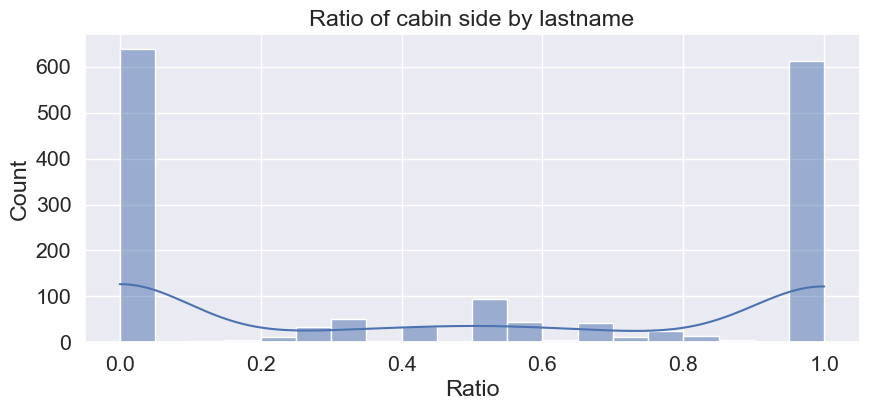

In [175]:
# Joint distribution of Cabin side and Lastname
LCS_gb = data[data['Group_size'] > 1].groupby(['Lastname', 'Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

LCS_gb['Ratio'] = LCS_gb['P'] / (LCS_gb['P'] + LCS_gb['S'])

plt.figure(figsize = (10, 4))
sns.histplot(x = LCS_gb['Ratio'], kde = True, binwidth = 0.05)
plt.title('Ratio of cabin side by lastname')
plt.show()

In [176]:
print('Percentage of families all on the same cabin side: ', 100 * np.round((LCS_gb['Ratio'].isin([0, 1])).sum() / len(LCS_gb), 3), '%')
LCS_gb

Percentage of families all on the same cabin side:  76.7 %


Cabin_side,P,S,Ratio
Lastname,,,
Acobson,0.0,3.0,0.000000
Acobsond,3.0,0.0,1.000000
Adavisons,6.0,0.0,1.000000
Admingried,0.0,4.0,0.000000
Aginge,3.0,0.0,1.000000
...,...,...,...
Wriggins,0.0,3.0,0.000000
Yanton,2.0,2.0,0.500000
Yatters,0.0,3.0,0.000000


Families are tend to be in the same side

In [177]:
# Missing values before
CS_before = data['Cabin_side'].isna().sum()

LCS_gb.drop('Ratio', axis = 1, inplace = True)

In [178]:
LCS_idx = data[data['Cabin_side'].isna()][(data[data['Cabin_side'].isna()]['Lastname']).isin(LCS_gb.index)].index

data.loc[LCS_idx, 'Cabin_side'] = data.iloc[LCS_idx, :]['Lastname'].map(lambda x: LCS_gb.idxmax(axis = 1)[x])

In [179]:
data.drop('Lastname', axis = 1, inplace = True)

In [180]:
print('Cabin_side missing values before:', CS_before)
print('Cabin_side missing values after:', data['Cabin_side'].isna().sum())

Cabin_side missing values before: 162
Cabin_side missing values after: 66


In [181]:
data['Cabin_side'].value_counts()

S    6504
P    6400
Name: Cabin_side, dtype: int64

In [182]:
# Filling out the rest of missing values by outliers
CS_before = data['Cabin_side'].isna().sum()

data.loc[data['Cabin_side'].isna(), 'Cabin_side'] = 'Z'

print('Cabin_side missing values before:', CS_before)
print('Cabin_side missing values after:', data['Cabin_side'].isna().sum())

Cabin_side missing values before: 66
Cabin_side missing values after: 0


##### Cabin deck and Group

In [183]:
# Missing values before
CD_before = data['Cabin_deck'].isna().sum()

GCD_idx = data[data['Cabin_deck'].isna()][(data[data['Cabin_deck'].isna()]['Group']).isin(GCD_gb.index)].index

data.loc[GCD_idx, 'Cabin_deck'] = data.iloc[GCD_idx, :]['Group'].map(lambda x: GCD_gb.idxmax(axis = 1)[x])

print('Cabin_deck missing values before:', CD_before)
print('Cabin_deck missing values after:', data['Cabin_deck'].isna().sum())

Cabin_deck missing values before: 299
Cabin_deck missing values after: 162


##### Cabin deck and Homeplanet

In [184]:
data.groupby(['HomePlanet', 'Destination', 'Solo', 'Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)

Cabin_deck                         A      B      C      D      E       F  \
HomePlanet Destination   Solo                                              
Earth      55 Cancri e   0       0.0    0.0    0.0    0.0   20.0    90.0   
                         1       0.0    0.0    0.0    0.0   47.0   289.0   
           PSO J318.5-22 0       0.0    0.0    0.0    0.0   18.0    67.0   
                         1       0.0    0.0    0.0    0.0   25.0   262.0   
           TRAPPIST-1e   0       0.0    0.0    0.0    0.0  133.0   438.0   
                         1       0.0    0.0    0.0    0.0  358.0  1350.0   
Europa     55 Cancri e   0      96.0  377.0  313.0   59.0   35.0     0.0   
                         1      67.0  141.0  159.0   46.0   34.0     0.0   
           PSO J318.5-22 0       2.0    5.0   11.0    0.0    0.0     0.0   
                         1       0.0    0.0   10.0    0.0    0.0     0.0   
           TRAPPIST-1e   0     152.0  459.0  428.0  120.0   53.0     0.0   
                         1      44.0  179.0  201.0   84.0   82.0     0.0   
Mars       55 Cancri e   0       0.0    0.0    0.0   32.0   15.0   104.0   
                         1       0.0    0.0    0.0   40.0   16.0    92.0   
           PSO J318.5-22 0       0.0    0.0    0.0    8.0    9.0    14.0   
                         1       0.0    0.0    0.0    9.0    7.0    21.0   
           TRAPPIST-1e   0       0.0    0.0    0.0  168.0  219.0   798.0   
                         1       0.0    0.0    0.0  164.0  263.0   743.0   

Cabin_deck                          G    T  
HomePlanet Destination   Solo               
Earth      55 Cancri e   0      272.0  0.0  
                         1      269.0  0.0  
           PSO J318.5-22 0      230.0  0.0  
                         1      466.0  0.0  
           TRAPPIST-1e   0     1075.0  0.0  
                         1     1509.0  0.0  
Europa     55 Cancri e   0        0.0  2.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  1.0  
                         1        0.0  8.0  
Mars       55 Cancri e   0        0.0  0.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  0.0  
                         1        0.0  0.0

People from Mars are more likely in deck F.
People from Europa are more likely in deck C if traveling solo and deck B otherwise.
People from Earth are more likely in deck G.

In [185]:
CD_before = data['Cabin_deck'].isna().sum()

CD_na_idx = data.loc[data['Cabin_deck'].isna(), 'Cabin_deck'].index
data.loc[data['Cabin_deck'].isna(), 'Cabin_deck'] = data.groupby(['HomePlanet', 'Destination', 'Solo'])['Cabin_deck'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[CD_na_idx]

print('Cabin_deck missing values before:', CD_before)
print('Cabin_deck missing values after:', data['Cabin_deck'].isna().sum())

Cabin_deck missing values before: 162
Cabin_deck missing values after: 0


##### Cabin Number and Cabin deck

Text(0.5, 1.0, 'Cabin number vs group colored by group')

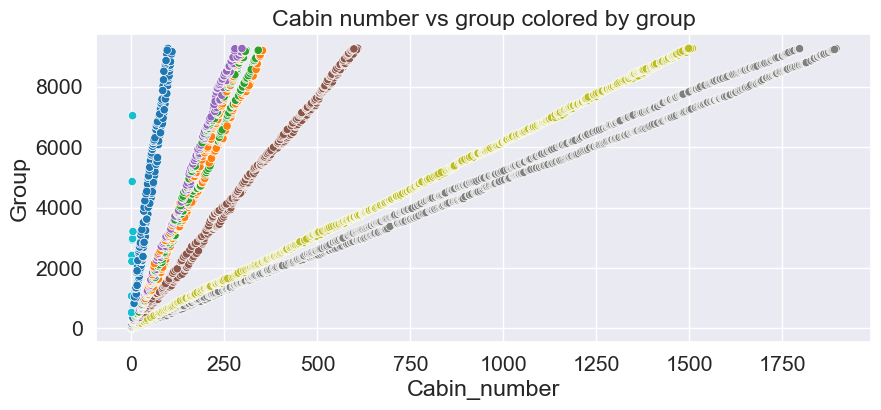

In [186]:
plt.figure(figsize = (10, 4))
sns.scatterplot(x = data['Cabin_number'], y = data['Group'], c = LabelEncoder().fit_transform(data.loc[~data['Cabin_number'].isna(), 'Cabin_deck']), cmap = 'tab10')
plt.title('Cabin number vs group colored by group')

Cabin number and group number share a linear relationship based on deck.

In [187]:
# Missing values before
CN_before = data['Cabin_number'].isna().sum()

# Extrapolate linear relationship on deck
for deck in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    X_CN = data.loc[~(data['Cabin_number'].isna()) & (data['Cabin_deck'] == deck), 'Group']
    y_CN = data.loc[~(data['Cabin_number'].isna()) & (data['Cabin_deck'] == deck), 'Cabin_number']

    X_test_CN = data.loc[(data['Cabin_number'].isna()) & (data['Cabin_deck'] == deck), 'Group']

    # Linear Regression
    model_CN = LinearRegression()
    model_CN.fit(X_CN.values.reshape(-1, 1), y_CN)

    pred_CN = model_CN.predict(X_test_CN.values.reshape(-1, 1))

    data.loc[(data['Cabin_number'].isna()) & (data['Cabin_deck'] == deck), 'Cabin_number'] = pred_CN.astype(int)

print('Cabin_number missing values before:', CN_before)
print('Cabin_number missing values after:', data['Cabin_number'].isna().sum())

Cabin_number missing values before: 299
Cabin_number missing values after: 0


Update Cabin regions

In [188]:
data['Cabin_region1'] = (data['Cabin_number'] < 300).astype(int)
data['Cabin_region2'] = ((data['Cabin_number'] >= 300) & (data['Cabin_number'] < 600)).astype(int)
data['Cabin_region3'] = ((data['Cabin_number'] >= 600) & (data['Cabin_number'] < 900)).astype(int)
data['Cabin_region4'] = ((data['Cabin_number'] >= 900) & (data['Cabin_number'] < 1200)).astype(int)
data['Cabin_region5'] = ((data['Cabin_number'] >= 1200) & (data['Cabin_number'] < 1500)).astype(int)
data['Cabin_region6'] = ((data['Cabin_number'] >= 1500) & (data['Cabin_number'] < 1800)).astype(int)
data['Cabin_region7'] = (data['Cabin_number'] >= 1800).astype(int)

##### VIP

In [189]:
data['VIP'].value_counts()

False    12401
True       273
Name: VIP, dtype: int64

In [190]:
# Missing values before
V_before = data['VIP'].isna().sum()
data.loc[data['VIP'].isna(), 'VIP'] = False

print('VIP missing values before:', V_before)
print('VIP missing values after:', data['VIP'].isna().sum())

VIP missing values before: 296
VIP missing values after: 0


##### Age

In [191]:
# Joint distribution
data.groupby(['HomePlanet', 'No_spending', 'Solo', 'Cabin_deck'])['Age'].median().unstack().fillna(0)

Cabin_deck                      A     B     C     D     E     F     G     T
HomePlanet No_spending Solo                                                
Earth      0           0      0.0   0.0   0.0   0.0  24.0  25.0  28.0   0.0
                       1      0.0   0.0   0.0   0.0  25.0  24.0  26.0   0.0
           1           0      0.0   0.0   0.0   0.0   7.0  16.0   8.0   0.0
                       1      0.0   0.0   0.0   0.0  21.0  21.5  23.0   0.0
Europa     0           0     35.0  34.0  33.0  33.0  34.0   0.0   0.0  44.0
                       1     35.0  36.0  35.5  34.0  35.0   0.0   0.0  35.0
           1           0     30.0  27.0  28.5  27.0  28.0   0.0   0.0   0.0
                       1     37.5  34.0  35.0  31.0  33.0   0.0   0.0   0.0
Mars       0           0      0.0   0.0   0.0  30.0  29.0  29.0   0.0   0.0
                       1      0.0   0.0   0.0  31.0  28.5  30.0   0.0   0.0
           1           0      0.0   0.0   0.0  29.5  26.0  18.0   0.0   0.0
                       1      0.0   0.0   0.0  33.0  30.0  29.5   0.0   0.0

In [192]:
A_before = data[exp_fea].isna().sum().sum()

na_age_rows = data.loc[data['Age'].isna(), 'Age'].index
data.loc[data['Age'].isna(), 'Age'] = data.groupby(['HomePlanet', 'No_spending', 'Solo', 'Cabin_deck'])['Age'].transform(lambda x: x.fillna(x.median()))[na_age_rows]

print('Age missing values before:', A_before)
print('Age missing values after:', data['Age'].isna().sum())

Age missing values before: 1410
Age missing values after: 0


In [193]:
data.loc[data['Age'] <= 12, 'Age_group'] = 'Age_0-12'
data.loc[(data['Age'] > 12) & (data['Age'] <= 18),'Age_group'] = 'Age_13-17'
data.loc[(data['Age'] > 18) & (data['Age'] <= 25),'Age_group'] = 'Age_18-25'
data.loc[(data['Age'] > 25) & (data['Age'] <= 30),'Age_group'] = 'Age_26-30'
data.loc[(data['Age'] > 30) & (data['Age'] <= 50),'Age_group'] = 'Age_31-50'
data.loc[data['Age'] > 50, 'Age_group'] = 'Age_51+'

##### CryoSleep

In [194]:
data.groupby(['No_spending', 'CryoSleep'])['CryoSleep'].size().unstack().fillna(0)

CryoSleep,False,True
No_spending,,
0,7339.0,0.0
1,740.0,4581.0


In [195]:
CSL_before = data['CryoSleep'].isna().sum()

na_cryo_rows = data.loc[data['CryoSleep'].isna(), 'CryoSleep'].index
data.loc[data['CryoSleep'].isna(), 'CryoSleep'] = data.groupby(['No_spending'])['CryoSleep'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_cryo_rows]

print('CryoSleep missing values before:', CSL_before)
print('CryoSleep missing values after:', data['CryoSleep'].isna().sum())

CryoSleep missing values before: 310
CryoSleep missing values after: 0


##### Expenditure and CryoSleep

In [196]:
print('Maximum expenditure of passengers in CryuSleep: ', data.loc[data['CryoSleep'] == True, exp_fea].sum(axis = 1).max())

Maximum expenditure of passengers in CryuSleep:  0.0


In [197]:
E_before = data[exp_fea].isna().sum().sum()

for col in exp_fea:
    data.loc[(data[col].isna()) & (data['CryoSleep'] == True), col] = 0

print('Expenditure missing values before:', E_before)
print('Expenditure missing values after:', data[exp_fea].isna().sum().sum())

Expenditure missing values before: 1410
Expenditure missing values after: 866


In [198]:
data.groupby(['HomePlanet', 'Solo', 'Age_group'])['Expenditure'].mean().unstack().fillna(0)

Age_group        Age_0-12    Age_13-17    Age_18-25    Age_26-30    Age_31-50  \
HomePlanet Solo                                                                 
Earth      0          0.0   725.122449   799.036017   841.093596   736.655773   
           1          0.0   703.192020   788.284852   795.420690   794.818627   
Europa     0          0.0  1350.567164  2735.909366  3534.668246  3975.774005   
           1          0.0  1887.958333  2354.517544  3806.000000  3949.939929   
Mars       0          0.0  1123.175141  1190.694915  1247.098361  1143.671916   
           1          0.0  1489.655172  1050.459459  1107.122677  1110.392045   

Age_group            Age_51+  
HomePlanet Solo               
Earth      0      733.649573  
           1      826.366972  
Europa     0     3483.639004  
           1     3952.085526  
Mars       0     1345.419643  
           1     1100.298387

In [199]:
E_before = data[exp_fea].isna().sum().sum()

for col in exp_fea:
    na_rows = data.loc[data[col].isna(), col].index
    data.loc[data[col].isna(), col] = data.groupby(['HomePlanet', 'Solo', 'Age_group'])[col].transform(lambda x: x.fillna(x.mean()))[na_rows]


print('Expenditure missing values before:', E_before)
print('Expenditure missing values after:', data[exp_fea].isna().sum().sum())

Expenditure missing values before: 866
Expenditure missing values after: 0


In [201]:
data['Expenditure'] = data[exp_fea].sum(axis = 1)
data['No_spending'] = (data['No_spending'] == 0).astype(int)

In [202]:
data.isna().sum()

PassengerId      0
HomePlanet       0
CryoSleep        0
Destination      0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Age_group        0
Expenditure      0
No_spending      0
Group            0
Group_size       0
Solo             0
Cabin_deck       0
Cabin_number     0
Cabin_side       0
Cabin_region1    0
Cabin_region2    0
Cabin_region3    0
Cabin_region4    0
Cabin_region5    0
Cabin_region6    0
Cabin_region7    0
Family_size      0
dtype: int64

## Preprossing

In [203]:
X_train = data[data['PassengerId'].isin(train['PassengerId'].values)].copy()
X_test = data[data['PassengerId'].isin(test['PassengerId'].values)].copy()

##### Drop qualitative/redundant/collinear/high cardinality features

In [204]:
X_train.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number'], axis = 1, inplace = True)
X_test.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number'], axis = 1, inplace = True)

##### Log transform to reduce skew

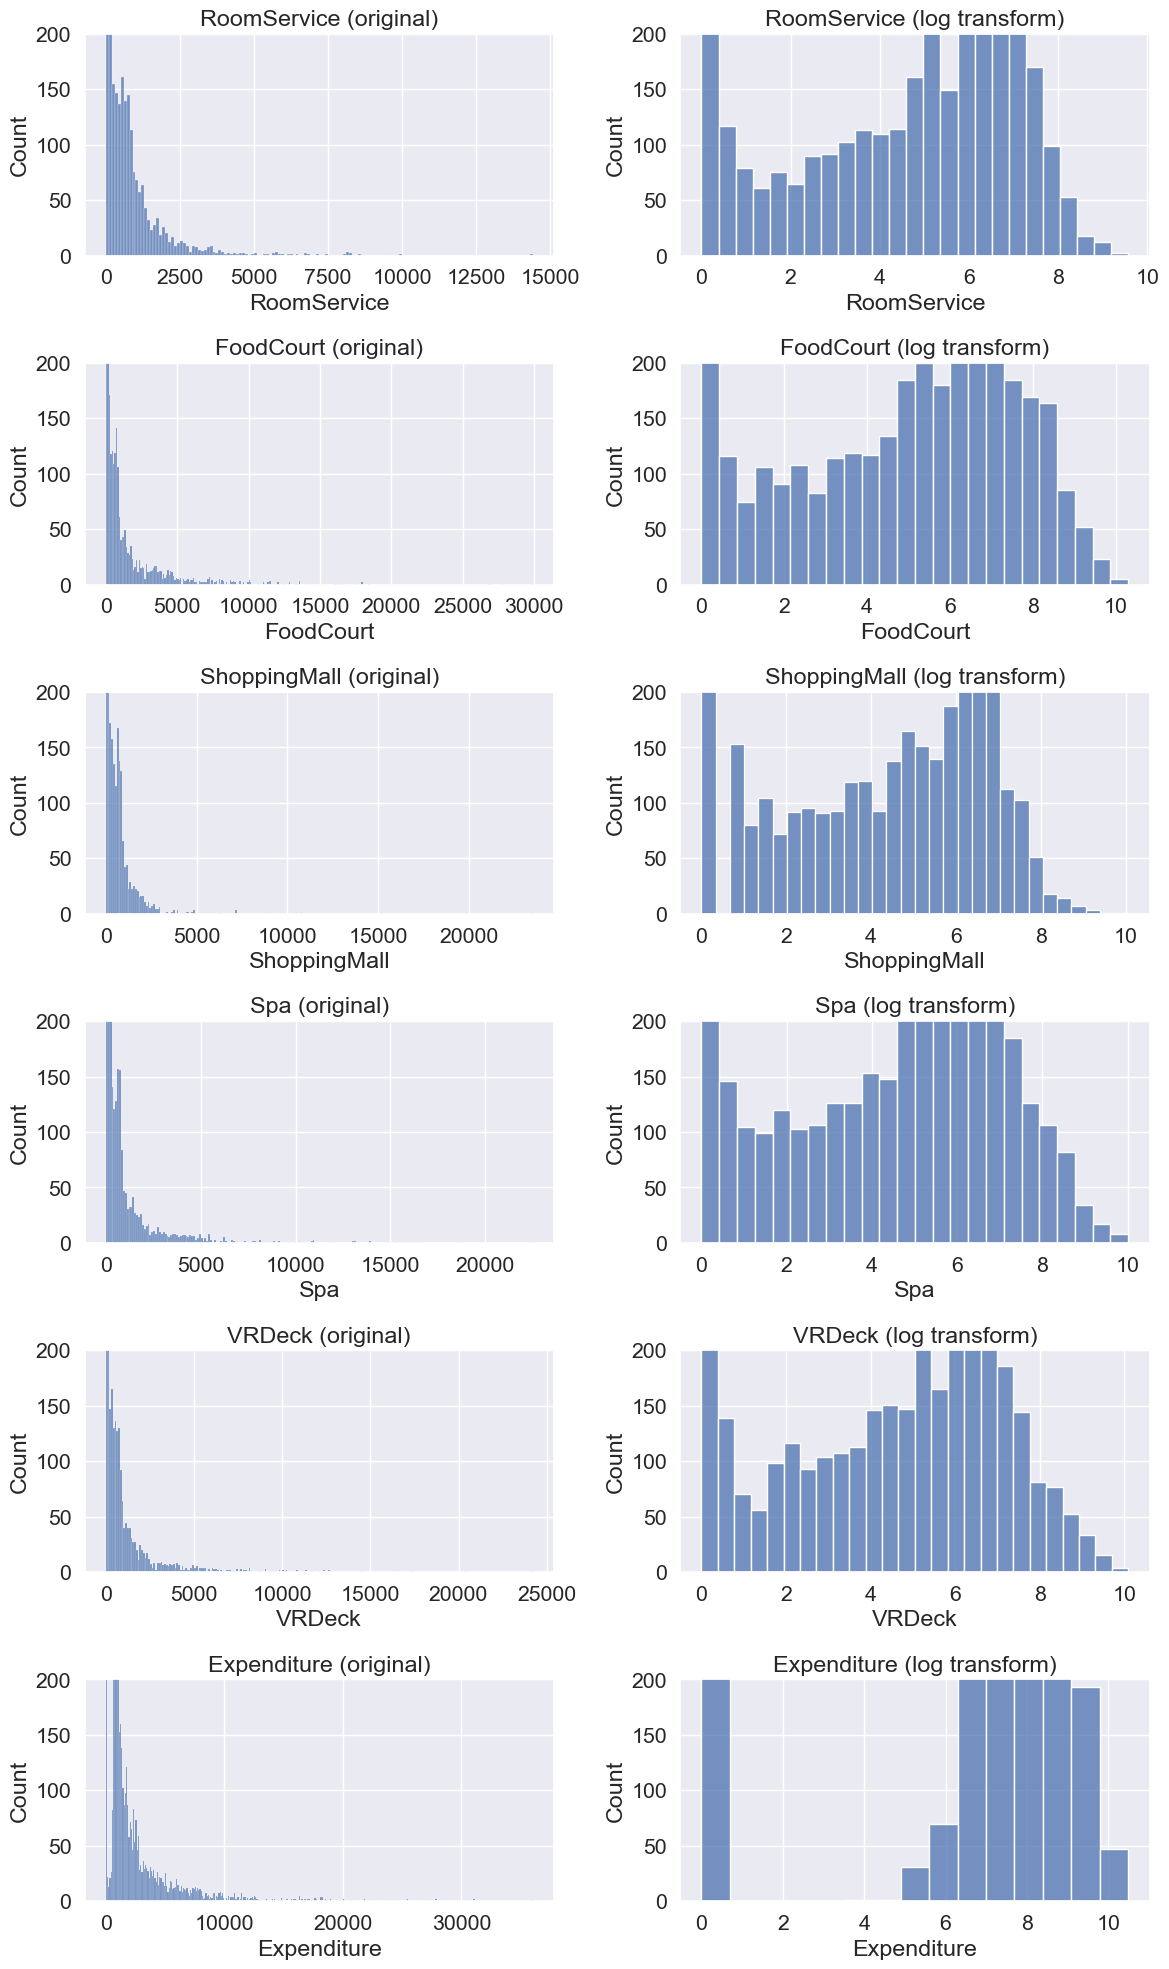

In [208]:
fig = plt.figure(figsize = (12, 20))

for i, col in enumerate(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenditure']):
    plt.subplot(6, 2, i * 2 + 1)
    sns.histplot(X_train[col], binwidth = 100)
    plt.ylim([0, 200])
    plt.title(f'{col} (original)')

    plt.subplot(6, 2, i * 2 + 2)
    sns.histplot(np.log(1 + X_train[col]))
    plt.ylim([0, 200])
    plt.title(f'{col} (log transform)')

fig.tight_layout()
plt.show()

##### Encoding and scaling with column transformer

In [209]:
# Indentify numberical and categorical columns
numerical_cols = [i for i in X_train.columns if X_train[i].dtype in ['int64', 'float64']]
categorical_cols = [i for i in X_train.columns if X_train[i].dtype == 'object']

# Scale numerical data to have mean = 0 and variance = 1
numerical__transformer = Pipeline(steps = [('scaler', StandardScaler())])

# One-hot encode categorical data
categorical_transformer = Pipeline(steps = [('onehot', OneHotEncoder(drop = 'if_binary', handle_unknown = 'ignore', sparse = False))])

# Combine preprocessing
ct = ColumnTransformer(
    transformers = [('num', numerical__transformer, numerical_cols),
                    ('cat', categorical_transformer, categorical_cols)],
    remainder = 'passthrough')

X_train = ct.fit_transform(X_train)
X_test = ct.fit_transform(X_test)

print('Training set shape: ', X_train.shape)

Training set shape:  (8693, 36)


##### PCA

In [211]:
pca = PCA(n_components = 3)
components = pca.fit_transform(X_train)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x = 0, y = 1, z = 2, color = y, size = 0.1 * np.ones(len(X_train)), opacity = 1,
    title = f'Total Explained Variance: {total_var: .2f}%',
    labels = {'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    width = 800, height = 500
)

fig.show()

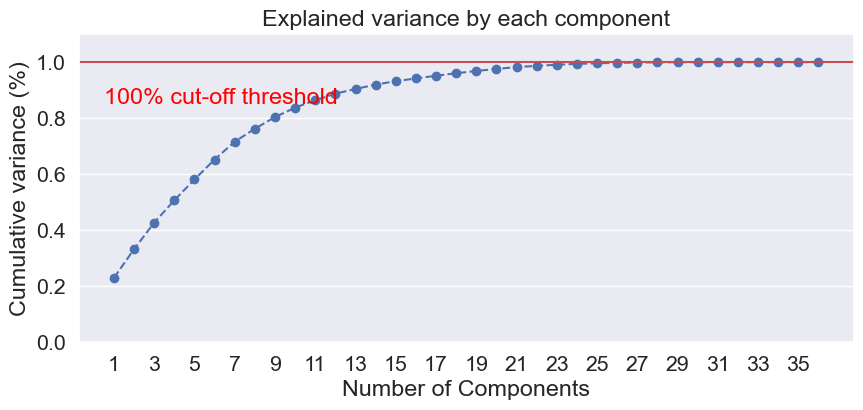

In [212]:
pca = PCA().fit(X_train)
fig, ax = plt.subplots(figsize = (10, 4))
xi = np.arange(1, 1 + X_train.shape[1], step = 1)
yi = np.cumsum(pca.explained_variance_ratio_)
plt.plot(xi, yi, marker = 'o', linestyle = '--', color = 'b')

plt.ylim(0.0, 1.1)
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 1 + X_train.shape[1], step = 2))
plt.ylabel('Cumulative variance (%)')
plt.title('Explained variance by each component')
plt.axhline(y = 1, color = 'r', linestyle = '-')
plt.text(0.5, 0.85, '100% cut-off threshold', color = 'red')
ax.grid(axis = 'x')

##### Validation set

In [213]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y, stratify = y, test_size = 0.2, random_state = 42)

## Model Selection